In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import csv
import svgwrite


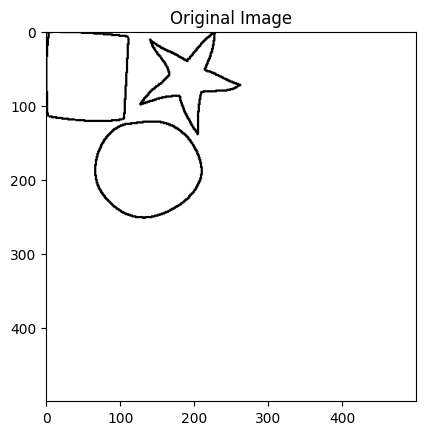

In [2]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot_paths(paths, image_size=(500, 500)):
    image = np.ones((*image_size, 3), dtype=np.uint8) * 255
    for path in paths:
        for segment in path:
            for i in range(len(segment) - 1):
                pt1 = tuple(map(int, segment[i]))
                pt2 = tuple(map(int, segment[i + 1]))
                cv2.line(image, pt1, pt2, (0, 0, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.show()
    return image

csv_path = 'problems/isolated.csv'
paths = read_csv(csv_path)
image = plot_paths(paths)


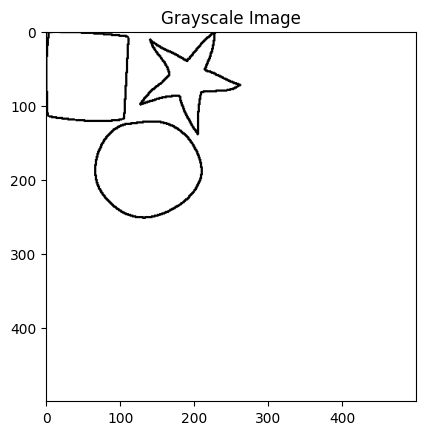

In [3]:
def convert_to_grayscale(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

gray_image = convert_to_grayscale(image)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.show()


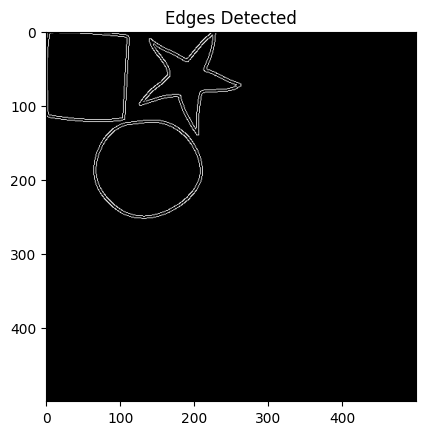

In [4]:
def apply_canny_edge_detection(gray_image, low_threshold=50, high_threshold=150):
    edges = cv2.Canny(gray_image, low_threshold, high_threshold)
    return edges

def detect_lines(edges, rho=1, theta=np.pi / 180, threshold=100, min_line_length=30, max_line_gap=5):
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)
    return lines

edges = apply_canny_edge_detection(gray_image)
lines = detect_lines(edges)

plt.imshow(edges, cmap='gray')
plt.title('Edges Detected')
plt.show()


In [5]:
def find_contours(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

contours = find_contours(edges)


Contour Area: 15355.0, Bounding Box: (64, 120, 148, 134)
Contour Area: 0.0, Bounding Box: (133, 95, 1, 1)
Contour Area: 0.0, Bounding Box: (131, 95, 1, 1)
Contour Area: 36.0, Bounding Box: (133, 21, 35, 73)
Contour Area: 36.5, Bounding Box: (135, 5, 123, 128)
Contour Area: 11857.5, Bounding Box: (1, 1, 109, 119)
Contour Area: 83.0, Bounding Box: (125, 0, 139, 141)
Contour Area: 1.5, Bounding Box: (0, 0, 113, 123)
Contour Area: 0.0, Bounding Box: (0, 0, 3, 18)


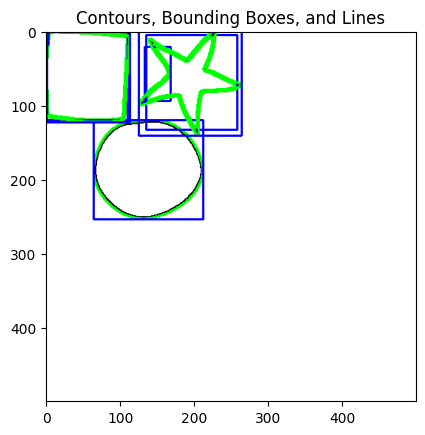

In [6]:
def draw_contours_and_lines(image, contours, lines):
    contour_image = image.copy()
    for contour in contours:
        cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(contour_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        print(f'Contour Area: {area}, Bounding Box: {(x, y, w, h)}')
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(contour_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    return contour_image

contour_image = draw_contours_and_lines(image, contours, lines)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title('Contours, Bounding Boxes, and Lines')
plt.show()


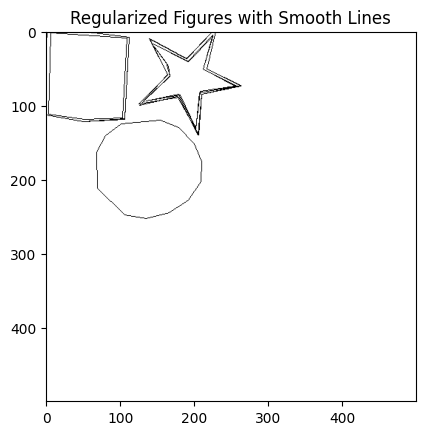

In [7]:
def approximate_contours(contours, epsilon_factor=0.01):
    approx_contours = []
    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approx_contours.append(approx)
    return approx_contours

def smooth_lines(image, lines):
    smooth_image = image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(smooth_image, (x1, y1), (x2, y2), (0, 0, 0), 2)
    return smooth_image

approx_contours = approximate_contours(contours)
regularized_image = np.ones((500, 500, 3), dtype=np.uint8) * 255 

for contour in approx_contours:
    cv2.drawContours(regularized_image, [contour], -1, (0, 0, 0), 1) 

regularized_image = smooth_lines(regularized_image, lines)

plt.imshow(cv2.cvtColor(regularized_image, cv2.COLOR_BGR2RGB))
plt.title('Regularized Figures with Smooth Lines')
plt.show()


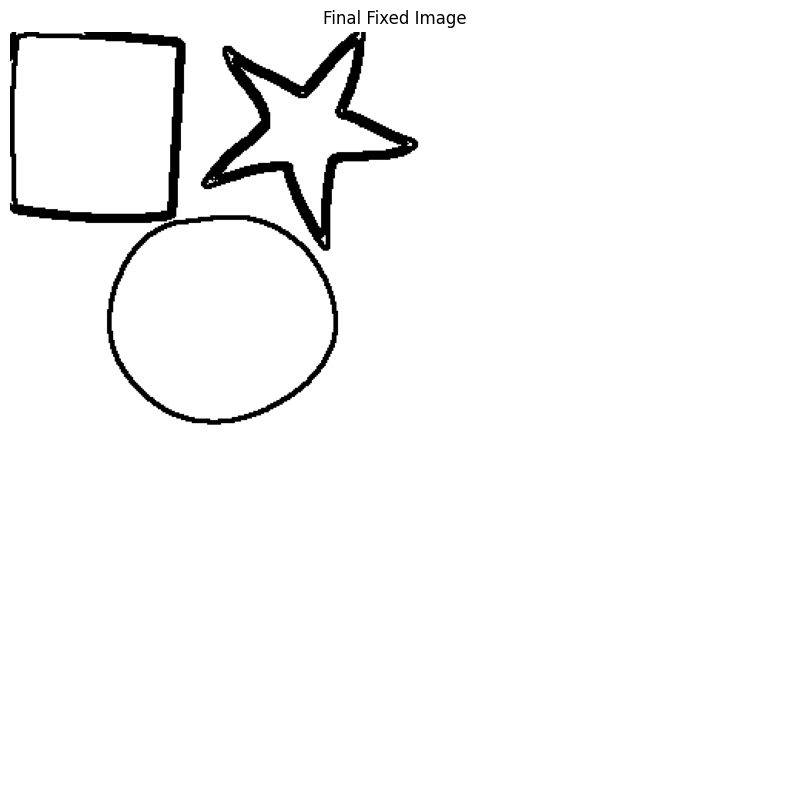

Fixed image saved as output/fixed_image.png
Contours properties saved as output/contours_properties.csv
Image saved as SVG at output/fixed_image.svg


In [9]:
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)
regularized_image = np.ones((500, 500, 3), dtype=np.uint8) * 255  
for contour in contours:
    cv2.drawContours(regularized_image, [contour], -1, (0, 0, 0), 2)
png_path = os.path.join(output_dir, 'fixed_image.png')
cv2.imwrite(png_path, cv2.cvtColor(regularized_image, cv2.COLOR_RGB2BGR))
csv_path = os.path.join(output_dir, 'contours_properties.csv')
with open(csv_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for contour in contours:
        for point in contour:
            csv_writer.writerow([f'{0:.18e}', f'{0:.18e}', f'{point[0][0]:.18e}', f'{point[0][1]:.18e}'])


def save_image_as_svg(image, filename):
    dwg = svgwrite.Drawing(filename, profile='tiny', size=(image.shape[1], image.shape[0]))
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    for y in range(gray_image.shape[0]):
        for x in range(gray_image.shape[1]):
            color = gray_image[y, x]
            if color < 255:
                dwg.add(dwg.rect((x, y), (1, 1), fill=svgwrite.rgb(color, color, color, '%')))
    dwg.save()

svg_path = os.path.join(output_dir, 'fixed_image.svg')
save_image_as_svg(regularized_image, svg_path)

plt.figure(figsize=(10, 10)) 
plt.imshow(cv2.cvtColor(regularized_image, cv2.COLOR_BGR2RGB))
plt.title('Final Fixed Image')
plt.axis('off')
plt.gca().set_aspect('equal', adjustable='box')  
plt.show()

print(f'Fixed image saved as {png_path}')
print(f'Contours properties saved as {csv_path}')
print(f'Image saved as SVG at {svg_path}')
